In [2]:
%matplotlib inline

In [3]:
import math
from scipy import optimize
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# Inputs

In [98]:
D = 0.1731
soil = "dense sand"
psi = math.radians(32)
c = 0
gamma_bar = 18000
W_tot = 214.78
burial_depth = 1
f = 0.6
shear_factor = 0.3
el_lengths = [1, 0.3, 1.5, 15]

# General

In [28]:
def soil_weight(gamma, D, H):
    return gamma * D * H

W_s = soil_weight(gamma_bar, D, burial_depth)
W_s

3115.8

# Axial

In [113]:
def depth_to_centreline(burial_depth, D):
    return burial_depth + 0.5*D

H = depth_to_centreline(burial_depth, D)
H

1.08655

In [115]:
def axial_soil_force(D, c, H, f, gamma_bar, psi):
    alpha = 0.608 - 0.123 * c - 0.274 / (c ** 2 + 1) + 0.695 / (c ** 3 + 1)
    K_0 = 1 - (math.sin(psi))
    return math.pi * D * alpha * c + math.pi * D * H * gamma_bar * (
        0.5 * (1 + K_0)
    ) * math.tan(f * psi)


T_us = [
    el_length * axial_soil_force(D, c, burial_depth, f, gamma_bar, psi)
    for el_length in el_lengths
]

T_us

[2505.5631597000697, 751.6689479100208, 3758.3447395501044, 37583.44739550105]

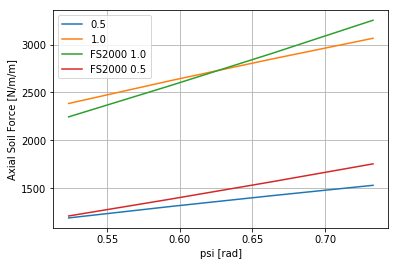

In [116]:
psis = np.arange(math.radians(30), math.radians(42), math.radians(4))

fig, ax = plt.subplots()

for b in np.arange(0.5, 1.5, 0.5):

    T_us = [
        axial_soil_force(D, c, b, f, gamma_bar, psi)
        for psi in psis
    ]

    ax.plot(psis, T_us, label=b)

a_stiff_1 = [2.246e3, 2.571e3, 2.906e3, 3.253e3]
a_stiff_05 = [1.213e3, 1.388e3, 1.569e3, 1.756e3]

ax.plot(psis, a_stiff_1, label="FS2000 1.0")
ax.plot(psis, a_stiff_05, label="FS2000 0.5")
    
ax.set_xlabel("psi [rad]")
ax.set_ylabel("Axial Soil Force [N/m/m]")
ax.legend()
ax.grid()
plt.show()

In [35]:
def axial_mobilisation(soil):
    delta_ts = {
        "dense sand": 0.003, "loose sand": 0.005, "stiff clay": 0.008, "soft clay": 0.01
    }
    return delta_ts.get(soil, ValueError("Unknown soil type."))

delta_t = axial_mobilisation(soil)

In [36]:
K_l = [T_u/delta_t for T_u in T_us]
K_l

[250556.31597000695, 1252781.5798500348, 12527815.798500348]

# Lateral

In [10]:
def N_ch(c, H, D):

    if c == 0:
        return 0
    x = H / D
    
    return min(6.752 + 0.065 * x - 11.063 / (x + 1) ** 2 + 7.119 / (x + 1) ** 3, 9)

In [157]:
def N_qh(psi, H, D):
    
    if psi == 0:
        return 0

    if psi < 20:
        psi = 20
    elif psi > 45:
        psi = 45
        
    psi_range = [20, 25, 30, 35, 40, 45]
    a = [2.399, 3.332, 4.565, 6.816, 10.959, 17.658]
    b = [0.439, 0.839, 1.234, 2.019, 1.783, 3.309]
    c = [-0.03, -0.09, -0.089, -0.146, 0.045, 0.048]
    d = [
        1.059 * 10 ** -3,
        5.606 * 10 ** -3,
        4.275 * 10 ** -3,
        7.651 * 10 ** -3,
        -5.425 * 10 ** -3,
        -6.443 * 10 ** -3
    ]
    e = [
        -1.754 * 10 ** -5,
        -1.319 * 10 ** -4,
        -9.159 * 10 ** -5,
        -1.683 * 10 ** -4,
        -1.153 * 10 ** -4,
        -1.299 * 10 ** -4
    ]
    x = H / D
    def par(case):
        return interp1d(psi_range, case)(psi)

    return (
        par(a) + par(b) * x + par(c) * x ** 2 + par(d) * x ** 3 + par(e) * x ** 4
    )

N_qh(psi, burial_depth, D)

4.1185315993155598

In [160]:
def lateral_soil_force(c, H, D, psi, gamma):
    return N_ch(c, H, D) * c * D + N_qh(psi, H, D) * gamma * H * D

P_u = lateral_soil_force(c, H, D, 32, gamma_bar)
P_u

40553.370302441428

In [68]:
def lateral_mobilisation(H, D):
    return min(0.04 * (H + D / 2), 0.15 * D)

delta_p = lateral_mobilisation(burial_depth, D)

0.125*D

0.0216375

In [71]:
def lateral_mobilisation_fs2000(H, D, bound='mid'):
    
    mob = {
        'lower': 0.1 * D,
        'mid': 0.125 * D,
        'upper': 1.15 * D,
    }
    
    return mob.get(bound, ValueError("Unknown soil type."))

lateral_mobilisation_fs2000(burial_depth, D, bound='mid')

0.0216375

In [14]:
K_l = P_u / delta_p
K_l

1395048.7629161475

# Vertical Uplift

In [15]:
def N_cv(c, H, D):

    if c == 0:
        return 0
    
    return min(2 * H / D, 10)
        

N_cv(c, H, D)

0

In [16]:
def N_q(psi):
    return math.exp(math.pi * math.tan(psi)) * math.tan((math.pi / 4) + 0.5 * psi) ** 2

N_q(psi)

23.176776207012633

In [41]:
def N_qv(psi, H, D):
    
    if psi == 0:
        return 0
    
    return min(math.degrees(psi) * H / 44 / D, N_q(psi))

N_qv(psi, burial_depth, D)

4.201460007352555

In [156]:
def vertical_uplift_force(psi, c, D, gamma, H):
    return N_cv(c, H, D) * c * D + N_qv(psi, H, D) * gamma * H * D

Q_us = [vertical_uplift_force(psi, c, D, gamma_bar, burial_depth) for burial_depth in np.arange(0.25, 1.25, 0.25)]
Q_us

[818.18181818181813, 3272.7272727272725, 7363.6363636363631, 13090.90909090909]

In [43]:
def vertical_uplift_mobilisation(soil, H, D):
    if "sand" in soil:
        return min(0.02 * H, 0.1 * D)

    elif "clay" in soil:
        return min(0.2 * H, 0.2 * D)

    else:
        raise ValueError("Unknown soil type.")

delta_qu = vertical_uplift_mobilisation(soil, burial_depth, D)
delta_qu

0.017310000000000002

In [20]:
k_vu = Q_u / delta_qu
k_vu

756262.8013234597

In [46]:
def uplift_resistance(shear_factor, H, D, gamma):
    """DNV-RP-F110 2007
    """
    return (1 + shear_factor * H / D) * (gamma * H * D)

R_max = uplift_resistance(shear_factor, burial_depth, D, gamma_bar)
R_max

8515.8

In [56]:
vertical_uplift = R_max - W_s
v = vertical_uplift * 0.3
v

1619.9999999999998

# Vertical Bearing

In [22]:
def cot(psi):
    return 1 / math.tan(psi)

In [23]:
def N_c(psi):
    return (N_q(psi) - 1)*cot(psi)

N_c(psi)

35.49026070689833

In [24]:
def N_gamma(psi):
    return 2*(N_q(psi) + 1)*math.tan(psi)

N_gamma(psi)

30.214652959465663

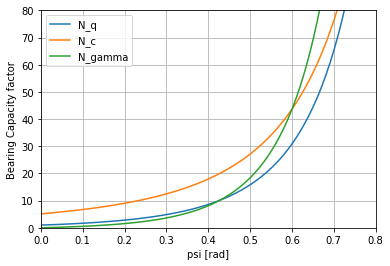

In [25]:
psis = np.arange(0.001, 0.8, 0.01)
N_qs = [N_q(psi) for psi in psis]
N_cs = [N_c(psi) for psi in psis]
N_gammas = [N_gamma(psi) for psi in psis]
fig, ax = plt.subplots()
ax.plot(psis, N_qs, label="N_q")
ax.plot(psis, N_cs, label="N_c")
ax.plot(psis, N_gammas, label="N_gamma")
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 80)
ax.set_xlabel("psi [rad]")
ax.set_ylabel("Bearing Capacity factor")
ax.legend()
ax.grid()
plt.show()

In [26]:
def penetration_depth(c, psi, gamma_bar, D, W_tot):   
    
    def B(z, D):
        if z <= 0.5*D:
            return 2*math.sqrt(z*(D-z))
        return D
    
    def Q_d(z):
        return (c*N_c(psi)+gamma_bar*z*N_q(psi)+0.5*gamma_bar*B(z, D)*N_gamma(psi))*B(z, D) - W_tot
    
    return optimize.newton(Q_d, 1e-3)

z = penetration_depth(c, psi, gamma_bar, D, W_tot)
z

0.0010820590598795271

In [27]:
k_vert = W_tot / z
k_vert

198491.938160855

In [67]:
def Qd(psi, c, D, gamma, H):

    return (
        N_c(psi) * c * D + N_q(psi) * gamma * H * D + N_gamma(psi) * (gamma + (1025 * 9.81)) * D ** 2 / 2
    )

Q_d = Qd(psi, c, D, gamma_bar, burial_depth)
Q_d

84913.97041133148

In [55]:
def vertical_downward_mobilisation(soil, D):
    
    if "sand" in soil:
        return 0.1 * D

    elif "clay" in soil:
        return 0.2 * D

    else:
        raise ValueError("Unknown soil type.")

delta_qd = vertical_downward_mobilisation(soil, D)
delta_qd

0.017310000000000002

# Foundation Profile 

In [142]:
E = 2.07e11
I = 1.6895e-05
W_sub = 193.34
gamma_factor = 1
delta = 0.5
element_length = 0.3

In [143]:
def natural_wavelength(gamma_factor, E, I, delta_f, W_sub):
    """Returns the factored natural wavelength i.e. the distance from prop to
    touchdown.

    JIP 

    :param E: Young's Modulus []
    :param I: Second moment of area []
    :param delta_f: 
    :W_sub: Submerged pipe weight [kg/m^3]
    """
    return gamma_factor * (72 * E * I * delta_f / W_sub) ** (1 / 4)

natural_wavelength(gamma_factor, E, I, delta, W_sub)

28.407128251897223

In [146]:
def foundation_profile(x, delta_f, L_o):
    """Returns the idealised imperfection profile.

    JIP    
    """
    return round(delta_f * (x / L_o) ** 3 * (4 - 3 * x / L_o), 4)

In [149]:
def determine_profile(element_length, delta, E, I, W_sub, gamma_factor):

    L_o = natural_wavelength(gamma_factor, E, I, delta, W_sub)
    xs = np.arange(L_o, 0, -element_length)
    w_fs = [foundation_profile(x, delta, L_o) for x in xs]
    return np.stack((xs, w_fs), axis=-1)

profile = determine_profile(element_length, delta, E, I, W_sub, gamma_factor)
profile

array([[  2.84071283e+01,   5.00000000e-01],
       [  2.81071283e+01,   4.99700000e-01],
       [  2.78071283e+01,   4.98700000e-01],
       [  2.75071283e+01,   4.97100000e-01],
       [  2.72071283e+01,   4.94900000e-01],
       [  2.69071283e+01,   4.92200000e-01],
       [  2.66071283e+01,   4.88900000e-01],
       [  2.63071283e+01,   4.85200000e-01],
       [  2.60071283e+01,   4.80900000e-01],
       [  2.57071283e+01,   4.76200000e-01],
       [  2.54071283e+01,   4.71100000e-01],
       [  2.51071283e+01,   4.65500000e-01],
       [  2.48071283e+01,   4.59600000e-01],
       [  2.45071283e+01,   4.53300000e-01],
       [  2.42071283e+01,   4.46600000e-01],
       [  2.39071283e+01,   4.39700000e-01],
       [  2.36071283e+01,   4.32400000e-01],
       [  2.33071283e+01,   4.24900000e-01],
       [  2.30071283e+01,   4.17100000e-01],
       [  2.27071283e+01,   4.09100000e-01],
       [  2.24071283e+01,   4.00900000e-01],
       [  2.21071283e+01,   3.92400000e-01],
       [  